# Sub-FOV Scan-phase

In [2]:
import masknmf
from pathlib import Path
import fastplotlib as fpl
import tifffile
import numpy as np

try:
    import mbo_utilities as mbo
except ImportError:
    print("uv pip install git+https://github.com/MillerBrainObservatory/mbo_utilities.git@dev")

In [5]:
import numpy as np
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

from mbo_utilities import log

TWO_DIM_PHASECORR_METHODS = {"frame"}
THREE_DIM_PHASECORR_METHODS = ["mean", "max", "std", "mean-sub"]

MBO_WINDOW_METHODS = {
    "mean":      lambda X: np.mean(X, axis=0),
    "max":       lambda X: np.max(X, axis=0),
    "std":       lambda X: np.std(X, axis=0),
    # pick first frame then subtract global mean
    "mean-sub":  lambda X: X[0] - np.mean(X, axis=0),
}

logger = log.get("phasecorr")


def _phase_corr_2d(
        frame,
        upsample=1,
):
    h, w = frame.shape
    pre, post = frame[::2], frame[1::2]
    shift, *_ = phase_cross_correlation(pre, post, upsample_factor=upsample)
    dx = float(shift[1])
    return dx

def _apply_offset(img, shift):
    """
    Apply one scalar `shift` (in X) to every *odd* row of an
    (..., Y, X) array.  Works for 2-D or 3-D stacks.
    """
    if img.ndim < 2:
        return img

    rows = img[..., 1::2, :]

    f = np.fft.fftn(rows, axes=(-2, -1))
    shift_vec = (0,) * (f.ndim - 1) + (shift,)   # e.g. (0,0,dx) for 3-D
    rows[:] = np.fft.ifftn(fourier_shift(f, shift_vec),
                           axes=(-2, -1)).real
    return img

def nd_windowed(arr, *, method="mean", upsample=1,
                max_offset=4, border=2):
    """Return (corrected array, offsets)."""
    a = np.asarray(arr)
    if a.ndim == 2:
        offs = _phase_corr_2d(a, upsample, border, max_offset)
    else:
        flat = a.reshape(a.shape[0], *a.shape[-2:])
        if method == "frame":
            offs = np.array(
                [_phase_corr_2d(f, upsample, border, max_offset) for f in flat]
            )
        else:
            if method not in MBO_WINDOW_METHODS:
                raise ValueError(f"unknown method {method}")
            img = MBO_WINDOW_METHODS[method](flat)
            offs = _phase_corr_2d(img, upsample, border, max_offset)
    if np.ndim(offs) == 0:  # scalar
        corrected = _apply_offset(a.copy(), float(offs))
    else:
        corrected = np.stack(
            [_apply_offset(f.copy(), float(s))  # or _apply_offset
             for f, s in zip(a, offs)]
        )
    return corrected, offs


def apply_scan_phase_offsets(arr, offs):
    out = np.asarray(arr).copy()
    if np.isscalar(offs):
        return _apply_offset(out, offs)
    for k, off in enumerate(offs):
        out[k] = _apply_offset(out[k], off)
    return out


In [15]:
raw_files = [x for x in Path(r"D:\tests_bigmem\roi2").glob("*.tif*")]
data_store = {}

for file in raw_files:
    data_store[file.stem] = tifffile.memmap(file)

In [13]:
data_store.keys()

dict_keys(['plane10', 'plane5', 'plane6', 'plane7', 'plane8', 'plane9'])

In [14]:
zplane_name = "plane9"

data = data_store[zplane_name]

In [22]:
offsets = np.array([_phase_corr_2d(frame, 10) for frame in data])

In [30]:
np.min(offsets)

np.float64(-0.9)

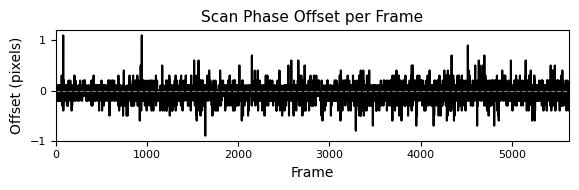

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(offsets, lw=1.5, color="black")
ax.axhline(0, color="gray", linestyle="--", lw=0.8)
ax.set_xlabel("Frame", fontsize=10)
ax.set_ylabel("Offset (pixels)", fontsize=10)
ax.set_xlim(0, len(offsets) - 1)
ax.tick_params(labelsize=8)
ax.set_title("Scan Phase Offset per Frame", fontsize=11)
fig.tight_layout()

TypeError: only integer scalar arrays can be converted to a scalar index

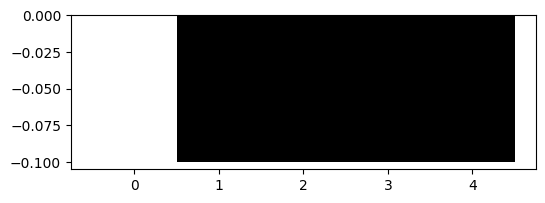

In [52]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 2))
x = np.arange(len(offsets))
ax.bar(x, offsets, width=1.0, color="black")

mask = np.abs(offsets) < 0.1
ax.bar(x[mask], offsets[mask], width=1.0, color="red")

ax.axhline(0, color="gray", linestyle="--", lw=0.8)
ax.set_xlim(0, len(offsets) - 1)
ax.set_xlabel("Frame", fontsize=10)
ax.set_ylabel("Offset (px)", fontsize=10)
ax.tick_params(labelsize=8)
fig.tight_layout()
plt.show()

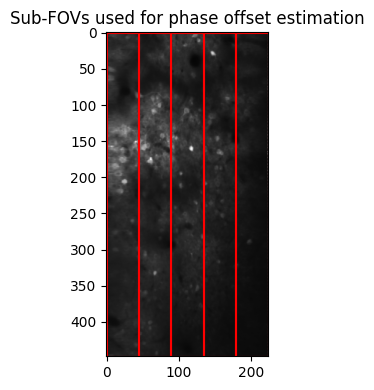

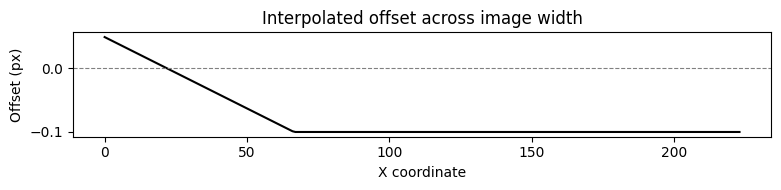

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from skimage.registration import phase_cross_correlation

def _phase_corr_2d(img, upsample=10):
    pre, post = img[::2], img[1::2]
    shift, *_ = phase_cross_correlation(pre, post, upsample_factor=upsample)
    return float(shift[1])

def phase_offsets_subfov(img, n_parts=3, upsample=10):
    h, w = img.shape
    xsplits = np.linspace(0, w, n_parts + 1, dtype=int)
    offsets = []

    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        patch = img[:, x0:x1]
        offsets.append(_phase_corr_2d(patch, upsample))

    patch_centers = [(xsplits[i] + xsplits[i+1]) / 2 for i in range(n_parts)]
    interp_fn = interp1d(patch_centers, offsets, kind="linear", bounds_error=False, fill_value="extrapolate")
    full_x = np.arange(w)
    interp_offsets = interp_fn(full_x)

    return xsplits, patch_centers, offsets, interp_offsets

# Example usage
mean_img = data.mean(0).astype(np.float32)
xsplits, patch_centers, offsets, interp_offsets = phase_offsets_subfov(mean_img, n_parts=5)

# Show patches on image
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(mean_img, cmap="gray")
for i in range(len(xsplits) - 1):
    x0, x1 = xsplits[i], xsplits[i + 1]
    rect = plt.Rectangle((x0, 0), x1 - x0, mean_img.shape[0], edgecolor="red", facecolor="none", linewidth=1.5)
    ax.add_patch(rect)
ax.set_title("Sub-FOVs used for phase offset estimation")
plt.tight_layout()

# Show interpolated offsets
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(interp_offsets, color="black")
ax.axhline(0, color="gray", linestyle="--", lw=0.8)
ax.set_title("Interpolated offset across image width")
ax.set_xlabel("X coordinate")
ax.set_ylabel("Offset (px)")
plt.tight_layout()


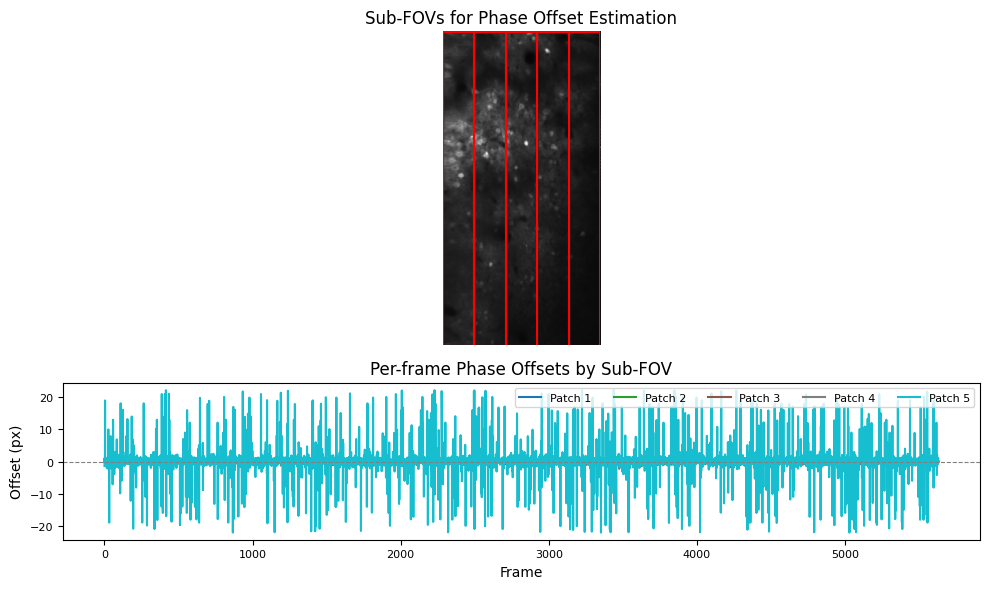

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation

def _phase_corr_2d(img, upsample=10):
    pre, post = img[::2], img[1::2]
    shift, *_ = phase_cross_correlation(pre, post, upsample_factor=upsample)
    return float(shift[1])

def phase_offsets_timecourse(data, n_parts=3, upsample=10):
    t, h, w = data.shape
    xsplits = np.linspace(0, w, n_parts + 1, dtype=int)
    offsets = []

    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        patch_offsets = []
        for frame in data:
            patch = frame[:, x0:x1]
            patch_offsets.append(_phase_corr_2d(patch, upsample))
        offsets.append(patch_offsets)

    return xsplits, np.array(offsets)  # shape: (n_parts, n_frames)

# Run
mean_img = data.mean(0).astype(np.float32)
xsplits, offsets = phase_offsets_timecourse(data, n_parts=5)
n_parts, n_frames = offsets.shape

# Plot
fig, (ax_img, ax_plot) = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[4, 2], sharex=False)

# Top: mean image with patch boundaries
ax_img.imshow(mean_img, cmap="gray")
for i in range(len(xsplits) - 1):
    x0, x1 = xsplits[i], xsplits[i + 1]
    rect = plt.Rectangle((x0, 0), x1 - x0, mean_img.shape[0], edgecolor="red", facecolor="none", linewidth=1.5)
    ax_img.add_patch(rect)
ax_img.set_title("Sub-FOVs for Phase Offset Estimation")
ax_img.axis("off")

colors = plt.cm.tab10(np.linspace(0, 1, n_parts))
for i in range(n_parts):
    ax_plot.plot(offsets[i], label=f"Patch {i+1}", color=colors[i])
ax_plot.axhline(0, color="gray", linestyle="--", lw=0.8)
ax_plot.set_title("Per-frame Phase Offsets by Sub-FOV")
ax_plot.set_xlabel("Frame")
ax_plot.set_ylabel("Offset (px)")
ax_plot.legend(loc="upper right", ncol=n_parts, fontsize=8)
ax_plot.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
